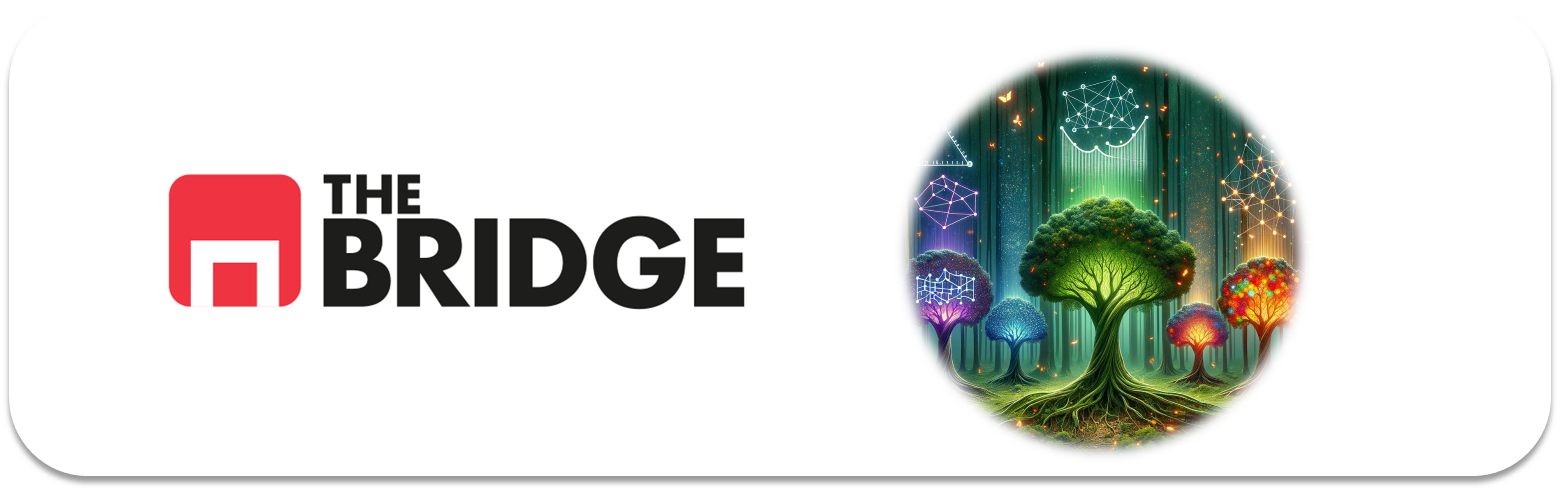

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, f1_score, make_scorer
)
import bootcampviztools as bvt


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [2]:
df = pd.read_csv("data/bank-full.csv", sep=";")
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:

print(df.info())
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


### Revisión
He revisado el dataset y tiene muchos `unknown`.


In [4]:
print("Nulos totales:", df.isna().sum().sum())

unknown_counts = {}
for col in df.select_dtypes(include="object").columns:
    unknown_counts[col] = (df[col] == "unknown").sum()

pd.Series(unknown_counts)


Nulos totales: 0


job            288
marital          0
education     1857
default          0
housing          0
loan             0
contact      13020
month            0
poutcome     36959
y                0
dtype: int64

(7, 2)


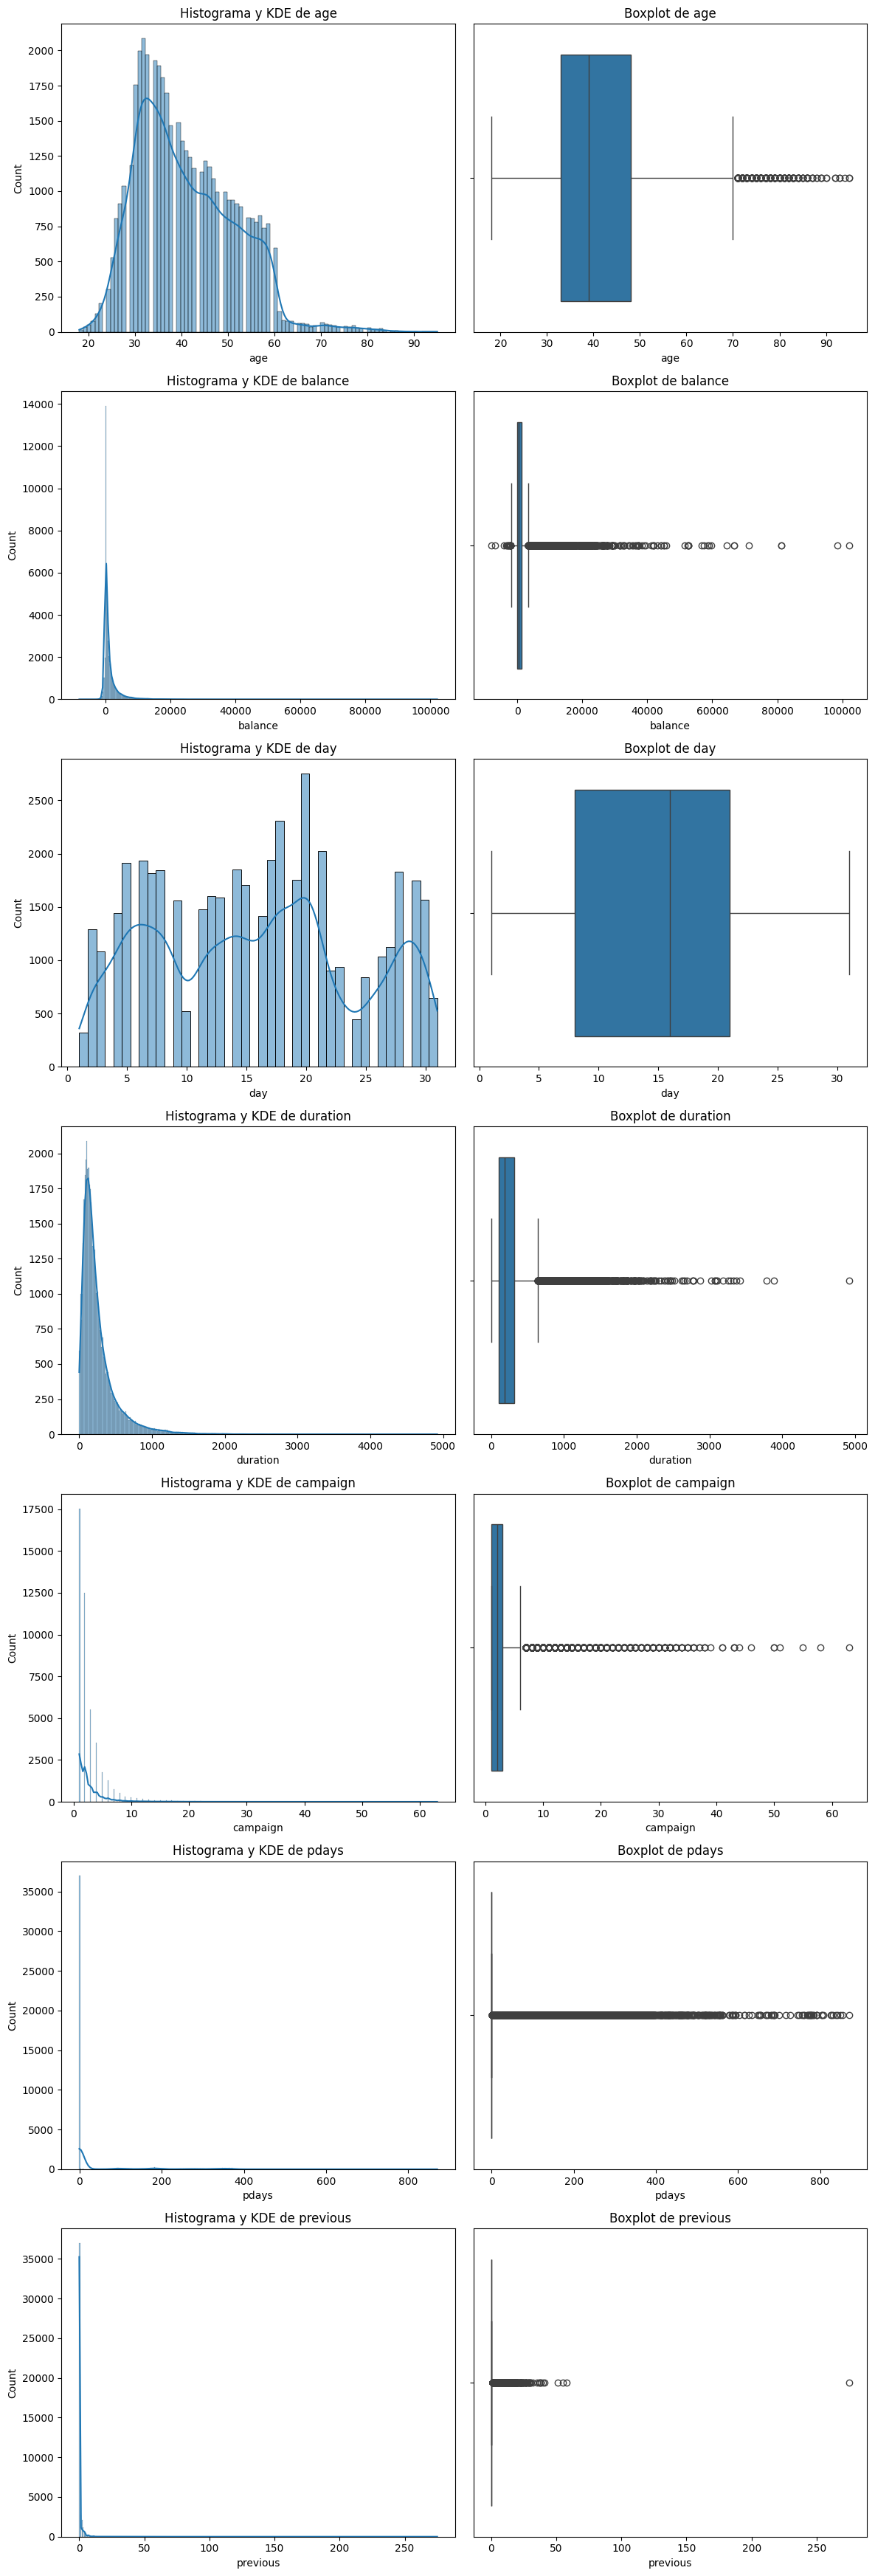

In [5]:
cols_num = ['age','balance','day','duration','campaign','pdays','previous']
bvt.plot_combined_graphs(df, cols_num)

## target y distribución


In [6]:
target = "y"
df[target].value_counts()


y
no     39922
yes     5289
Name: count, dtype: int64

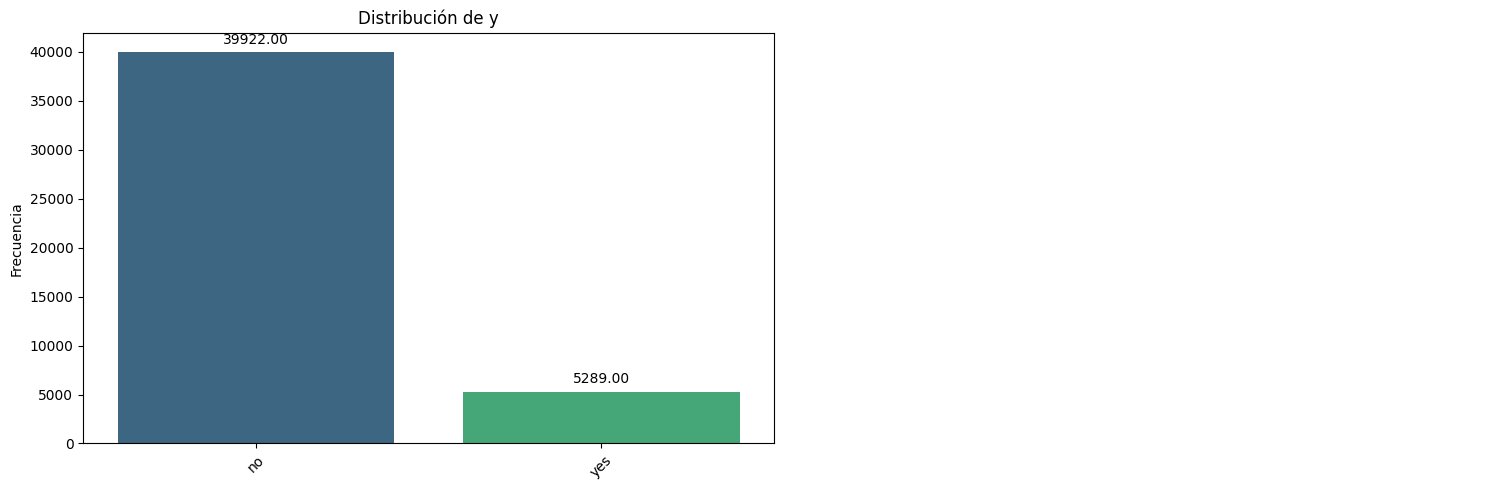

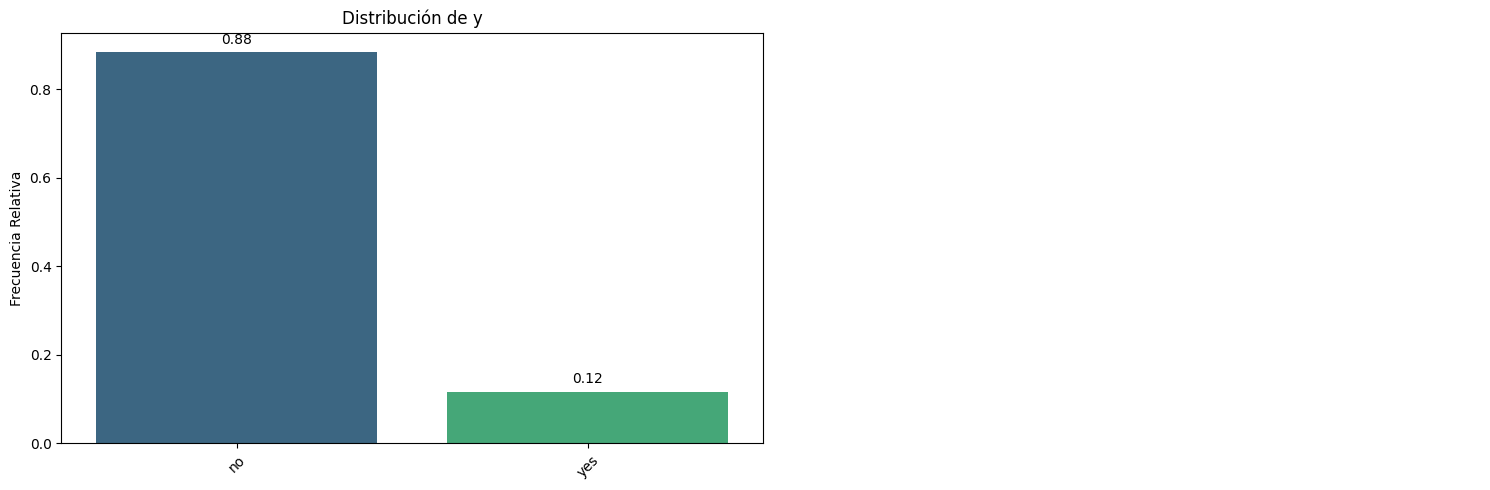

In [7]:
bvt.pinta_distribucion_categoricas(df, target, relativa=False, mostrar_valores=True)
bvt.pinta_distribucion_categoricas(df, target, relativa=True, mostrar_valores=True)


## Separación de features y target


In [8]:
X = df.drop(columns=[target])
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (45211, 16)
y shape: (45211,)


## Train/Test split



In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("*************TRAIN***************")
print(y_train.value_counts())
print("*************TEST***************")
print(y_test.value_counts())


*************TRAIN***************
y
no     31937
yes     4231
Name: count, dtype: int64
*************TEST***************
y
no     7985
yes    1058
Name: count, dtype: int64


## Preprocesado: One-Hot Encoding + Escalado
Hay variables categóricas, y se necesitan convertirlas a números.

Por eso se utilizará:
- `pd.get_dummies(...)` para One-Hot Encoding
- `StandardScaler` para escalar por la regresión logística


In [10]:
X_train_enc = pd.get_dummies(X_train, drop_first=False)
X_test_enc = pd.get_dummies(X_test, drop_first=False)


print("Train encoded:", X_train_enc.shape)
print("Test encoded :", X_test_enc.shape)


Train encoded: (36168, 51)
Test encoded : (9043, 51)


In [11]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

X_train_scaled.shape, X_test_scaled.shape


((36168, 51), (9043, 51))

## Regresión Logística (sin optimizar)
Entrenamos una **LogisticRegression** con hiperparámetros por defecto.



In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

          no       0.92      0.97      0.95      7985
         yes       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



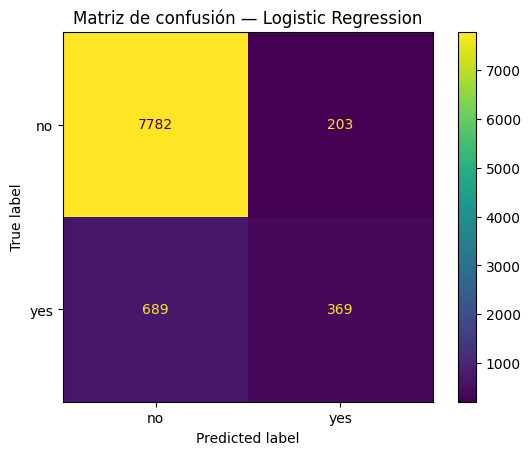

In [13]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["no", "yes"])
disp.plot(values_format="d")
plt.title("Matriz de confusión — Logistic Regression")
plt.show()


## Arbol de Decisión con entrenamiento
Entrenamos un árbol con todo por defecto.


In [14]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train_enc, y_train)   

y_pred_dt = dt_default.predict(X_test_enc)
y_proba_dt = dt_default.predict_proba(X_test_enc)[:, 1]

print("Classification report (Decision Tree - default):")
print(classification_report(y_test, y_pred_dt))


Classification report (Decision Tree - default):
              precision    recall  f1-score   support

          no       0.93      0.93      0.93      7985
         yes       0.46      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.70      0.70      9043
weighted avg       0.88      0.87      0.87      9043



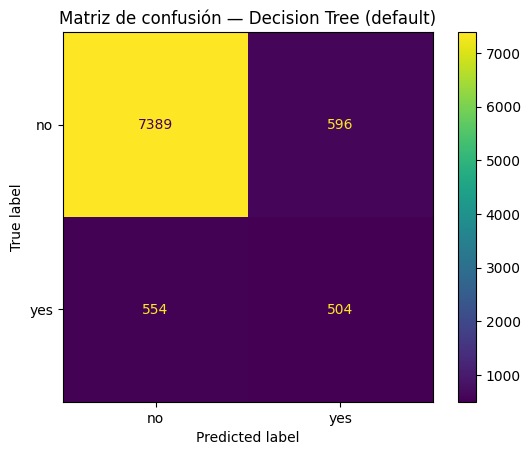

In [15]:
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=["no", "yes"])
ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["no", "yes"]).plot(values_format="d")
plt.title("Matriz de confusión — Decision Tree (default)")
plt.show()


## Vamos a optimizar los hiperparametros, y utilizaremos GridSearchCV

- `max_depth`: controla la profundidad; limita sobreajuste.
- `min_samples_split`: mínimo de muestras para dividir un nodo; evita particiones con pocos datos.
- `min_samples_leaf`: mínimo de muestras en una hoja; suaviza el modelo.
- `class_weight`: con desbalance, `balanced` puede ayudar a mejorar el recall de `yes`.

Como hay desbalanceo, optimizamos F1 de la clase positiva (`yes`) usando un `scorer` personalizado.


In [16]:
f1_yes = make_scorer(f1_score, pos_label="yes")

param_grid = {
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_split": [2, 10, 50, 100],
    "min_samples_leaf": [1, 5, 10, 50],
    "class_weight": [None, "balanced"]
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring=f1_yes,
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train_enc, y_train)

print("Mejor score CV (F1_yes):", round(grid.best_score_, 4))
print("Mejores hiperparámetros:", grid.best_params_)


Mejor score CV (F1_yes): 0.5444
Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 100}


### Evaluación del mejor árbol en test


              precision    recall  f1-score   support

          no       0.98      0.82      0.90      7985
         yes       0.40      0.87      0.55      1058

    accuracy                           0.83      9043
   macro avg       0.69      0.85      0.72      9043
weighted avg       0.91      0.83      0.85      9043



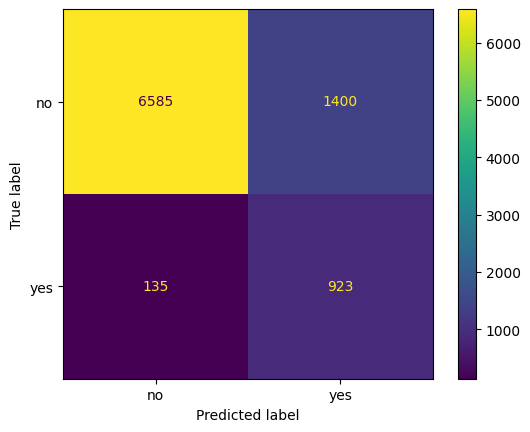

In [17]:
best_dt = grid.best_estimator_

y_pred_best = best_dt.predict(X_test_enc)
y_proba_best = best_dt.predict_proba(X_test_enc)[:, 1]

print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=["no", "yes"])
ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["no", "yes"]).plot(values_format="d")
plt.show()



## Interpretación del árbol
Vemos cual es la variable mas importante para separar los yes de los no


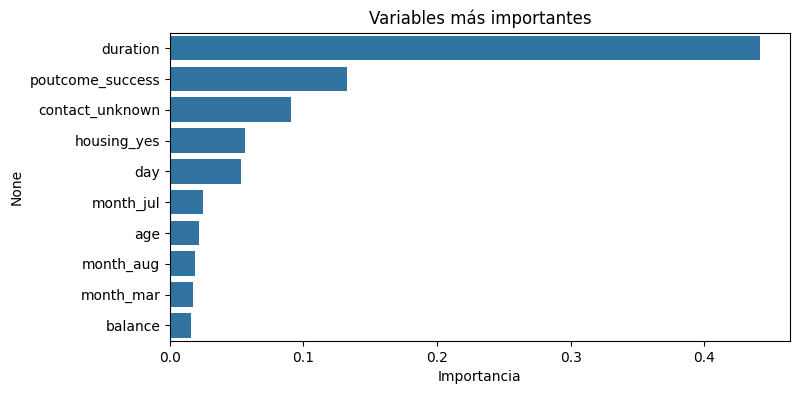

duration            0.442064
poutcome_success    0.132214
contact_unknown     0.090609
housing_yes         0.056134
day                 0.053227
month_jul           0.024868
age                 0.021661
month_aug           0.018744
month_mar           0.017183
balance             0.015622
dtype: float64

In [18]:
importances = pd.Series(best_dt.feature_importances_, index=X_train_enc.columns)
top = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top.values, y=top.index)
plt.title("Variables más importantes")
plt.xlabel("Importancia")
plt.show()

top


## Conclusión 
En este dataset hay desbalance muchos `no` y pocos `yes`.

- Creo que la regresión logística es un buen punto para el caso base, ya que como se ha comentado en los workout suele dar resultados estables.
- El árbol, sin "tunearlo" creo que sobreajusta y empeora el test, según se puede ver al utilizar el GridSearchCV
- Con GridSearchCV y unos buenos hiperparámetros, se mejora la precision para la clase `yes`.

En otro ipynb voy a mirar los modelos ensemble para ver como mejoran al modelo actual
